<a href="https://colab.research.google.com/github/lailasaummi/HCI-Scorecard-Model/blob/main/Home_Credit_Scorecard_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

*   Goal: Build a model to predict capabilities of each applicant for repay the loan (credit score)
*   Objective: Credit Scorecard Automatically Predicted Using Machine Learning Model
*   Metrics: Confusion, Recall, Precision, AUC




# Data Description

This dataset is provided by Home Credit with 8 main data, such as: application_train, application_test, bureau, bureau_balance, previous_application, POS_CASH_BALANCE, credit_card_balance and installments_payments. Also 2 additional data, such as: sample_submission and HomeCredit_columns_description. 

---

● **application_{train|test}.csv**

> ○ This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).

> ○ Static data for all applications. One row represents one loan in our data sample.

● **bureau.csv**
> ○ All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).

> ○ For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

● **bureau_balance.csv**
> ○ Monthly balances of previous credits in Credit Bureau.

> ○ This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

● **POS_CASH_balance.csv**
> ○ Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.

> ○ This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

● **credit_card_balance.csv**
> ○ Monthly balance snapshots of previous credit cards that the applicant has with
Home Credit.

> ○ This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

● **previous_application.csv**
> ○ All previous applications for Home Credit loans of clients who have loans in our sample.

> ○ There is one row for each previous application related to loans in our data sample.

● **installments_payments.csv**
> ○ Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.

> ○ There is a) one row for every payment that was made plus b) one row each for missed payment.
> ○ One row is equivalent to one payment of one installment OR one installment
corresponding to one payment of one previous Home Credit credit related to loans
in our sample.

● **HomeCredit_columns_description.csv**
> This file contains descriptions for the columns in the various data files.

● **sample_submission.csv**
> This file contains of `SK_ID_CURR` and `TARGET` columns


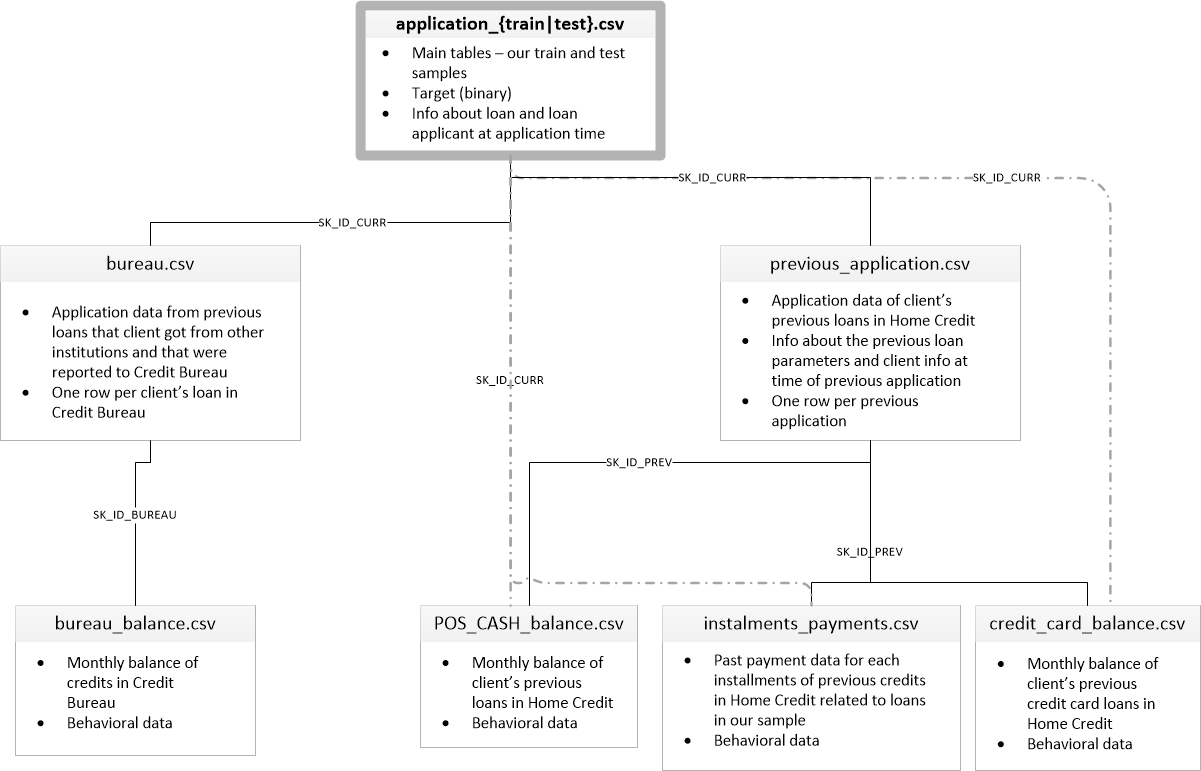

# Import Necessary Package

In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.io as pio
pio.renderers.default = "colab"
from sklearn.model_selection import train_test_split
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
import pickle
import gc
import lightgbm as lgb
warnings.filterwarnings('ignore')
%matplotlib inline

# Load Data

We are using **application_train.csv** file :
1. Each row has unique `SK_ID_CURR` and the output label is in the `TARGET` column.
2. `TARGET` indicating 0 means: the loan was repaid or 1 means: the loan has difficult payment.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
app_train = pd.read_csv('/content/drive/MyDrive/!!!/Rakamin Academy/VIX Home Credit /Home Credit Scorecard Model/application_train.csv')
print('The shape of data:',app_train.shape)
app_train.head()

Mounted at /content/drive
The shape of data: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Exploratory Data Analysis

## Missing Value

In [3]:
count = app_train.isnull().sum().sort_values(ascending=False)
percentage = ((app_train.isnull().sum()/len(app_train)*100)).sort_values(ascending=False)
missing_app_train = pd.concat([count, percentage], axis=1, keys=['Count','Percentage'])
missing_app_train.head(20)

,Count,Percentage
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953


## Duplicate Data

In [4]:
columns_without_id = [col for col in app_train.columns if col!='SK_ID_CURR']
app_train[app_train.duplicated(subset = columns_without_id, keep=False)]
print('Duplicates in the data:',app_train[app_train.duplicated(subset = columns_without_id, keep=False)]
      .shape[0])

Duplicates in the data: 0


## Distribution of Target Data

In [5]:
import plotly.io as pio
pio.renderers.default = "colab"

In [6]:
cf.set_config_file(theme='polar')
contract_val = app_train['NAME_CONTRACT_TYPE'].value_counts()
contract_df = pd.DataFrame({'labels': contract_val.index,
                   'values': contract_val.values
                  })
contract_df.iplot(kind='pie',labels='labels',values='values', title='Types of Loan', hole = 0.6)

Observations:
1. The data is imbalanced (90.5%(Loan repayed(0)) and 9.52%(Loan has difficult payment(1)).

## Distribution of Income Sources of Applicants

In [7]:
import plotly.io as pio
pio.renderers.default = "colab"

In [8]:
income_val = app_train['NAME_INCOME_TYPE'].value_counts()
income_val_y0 = []
income_val_y1 = []
for val in income_val.index:
    income_val_y1.append(np.sum(app_train['TARGET'][app_train['NAME_INCOME_TYPE']==val] == 1))
    income_val_y0.append(np.sum(app_train['TARGET'][app_train['NAME_INCOME_TYPE']==val] == 0))
data = [go.Bar(x = income_val.index, y = ((income_val_y1 / income_val.sum()) * 100), name='Yes' ),
        go.Bar(x = income_val.index, y = ((income_val_y0 / income_val.sum()) * 100), name='No' )]
layout = go.Layout(
    title = "Income sources of Applicants in %",
    xaxis=dict(
        title='Income source',
       ),
    yaxis=dict(
        title='Count of applicants in %',
        )
)
fig = go.Figure(data = data, layout=layout) 
iplot(fig)

Observations:
1. All the Students and Businessman are repaying loan.

# Modelling

## Train-Test Split

In [9]:
y = app_train.pop('TARGET').values
X_train, X_temp, y_train, y_temp = train_test_split(app_train.drop(['SK_ID_CURR'],axis=1), y, stratify = y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify = y_temp, test_size=0.5, random_state=42)
print('Shape of X_train:',X_train.shape)
print('Shape of X_val:',X_val.shape)
print('Shape of X_test:',X_test.shape)

Shape of X_train: (215257, 120)
Shape of X_val: (46127, 120)
Shape of X_test: (46127, 120)


In [10]:
# Separation of columns into numeric and categorical columns
types = np.array([dt for dt in X_train.dtypes])
all_columns = X_train.columns.values
is_num = types != 'object'
num_cols = all_columns[is_num]
cat_cols = all_columns[~is_num]
# Featurization of numeric data
imputer_num = SimpleImputer(strategy='median')
X_train_num = imputer_num.fit_transform(X_train[num_cols])
X_val_num = imputer_num.transform(X_val[num_cols])
X_test_num = imputer_num.transform(X_test[num_cols])
scaler_num = StandardScaler()
X_train_num1 = scaler_num.fit_transform(X_train_num)
X_val_num1 = scaler_num.transform(X_val_num)
X_test_num1 = scaler_num.transform(X_test_num)
X_train_num_final = pd.DataFrame(X_train_num1, columns=num_cols)
X_val_num_final = pd.DataFrame(X_val_num1, columns=num_cols)
X_test_num_final = pd.DataFrame(X_test_num1, columns=num_cols)
# Featurization of categorical data
imputer_cat = SimpleImputer(strategy='constant', fill_value='MISSING')
X_train_cat = imputer_cat.fit_transform(X_train[cat_cols])
X_val_cat = imputer_cat.transform(X_val[cat_cols])
X_test_cat = imputer_cat.transform(X_test[cat_cols])
X_train_cat1= pd.DataFrame(X_train_cat, columns=cat_cols)
X_val_cat1= pd.DataFrame(X_val_cat, columns=cat_cols)
X_test_cat1= pd.DataFrame(X_test_cat, columns=cat_cols)
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
X_train_cat2 = ohe.fit_transform(X_train_cat1)
X_val_cat2 = ohe.transform(X_val_cat1)
X_test_cat2 = ohe.transform(X_test_cat1)
cat_cols_ohe = list(ohe.get_feature_names(input_features=cat_cols))
X_train_cat_final = pd.DataFrame(X_train_cat2, columns = cat_cols_ohe)
X_val_cat_final = pd.DataFrame(X_val_cat2, columns = cat_cols_ohe)
X_test_cat_final = pd.DataFrame(X_test_cat2, columns = cat_cols_ohe)
# Final complete data
X_train_final = pd.concat([X_train_num_final,X_train_cat_final], axis = 1)
X_val_final = pd.concat([X_val_num_final,X_val_cat_final], axis = 1)
X_test_final = pd.concat([X_test_num_final,X_test_cat_final], axis = 1)
print(X_train_final.shape)
print(X_val_final.shape)
print(X_test_final.shape)

(215257, 250)
(46127, 250)
(46127, 250)


In [11]:
# Save the Dataframes into CSV files
X_train_final.to_csv('X_train_final.csv')
X_val_final.to_csv('X_val_final.csv')
X_test_final.to_csv('X_test_final.csv')
# Save the numpy arrays into text files
np.savetxt('y.txt', y)
np.savetxt('y_train.txt', y_train)
np.savetxt('y_val.txt', y_val)
np.savetxt('y_test.txt', y_test)

## Feature Selection

In [12]:
model_sk = lgb.LGBMClassifier(boosting_type='gbdt', max_depth=7, learning_rate=0.01, n_estimators= 2000, 
                 class_weight='balanced', subsample=0.9, colsample_bytree= 0.8, n_jobs=-1)
train_features, valid_features, train_y, valid_y = train_test_split(X_train_final, y_train, test_size = 0.15, random_state = 42)
model_sk.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], eval_metric = 'auc', verbose = 200)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.600955	valid_0's auc: 0.741425
[400]	valid_0's binary_logloss: 0.58292	valid_0's auc: 0.750074
[600]	valid_0's binary_logloss: 0.573681	valid_0's auc: 0.75331
[800]	valid_0's binary_logloss: 0.567247	valid_0's auc: 0.754348
[1000]	valid_0's binary_logloss: 0.56196	valid_0's auc: 0.754873
[1200]	valid_0's binary_logloss: 0.557558	valid_0's auc: 0.755033
Early stopping, best iteration is:
[1128]	valid_0's binary_logloss: 0.559057	valid_0's auc: 0.755071


LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               learning_rate=0.01, max_depth=7, n_estimators=2000,
               subsample=0.9)

In [13]:
feature_imp = pd.DataFrame(sorted(zip(model_sk.feature_importances_, X_train_final.columns)), columns=['Value','Feature'])
features_df = feature_imp.sort_values(by="Value", ascending=False)
selected_features = list(features_df[features_df['Value']>=50]['Feature'])
# Saving the selected features into pickle file
with open('select_features.txt','wb') as fp:
    pickle.dump(selected_features, fp)
print('The number of features selected:',len(selected_features))

The number of features selected: 105


In [14]:
import plotly.io as pio
pio.renderers.default = "colab"

In [15]:
# Feature importance Plot
data1 = features_df.head(20)
data = [go.Bar(x =data1.sort_values(by='Value')['Value'] , y = data1.sort_values(by='Value')['Feature'], orientation = 'h',
              marker = dict(
        color = 'rgba(43, 13, 150, 0.6)',
        line = dict(
            color = 'rgba(43, 13, 150, 1.0)',
            width = 1.5)
    )) ]
layout = go.Layout(
    autosize=False,
    width=1300,
    height=700,
    title = "Top 20 important features",
    xaxis=dict(
        title='Importance value'
        ),
    yaxis=dict(
        automargin=True
        ),
    bargap=0.4
    )
fig = go.Figure(data = data, layout=layout)
fig.layout.template = 'seaborn'
py.iplot(fig)

## Confusion Matrix and Cross Validation

In [17]:
def plot_confusion_matrix(test_y, predicted_y):
    # Confusion matrix
    C = confusion_matrix(test_y, predicted_y)
    
    # Recall matrix
    A = (((C.T)/(C.sum(axis=1))).T)
    
    # Precision matrix
    B = (C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = ['Re-paid(0)','Not Re-paid(1)']
    cmap=sns.light_palette("purple")
    plt.subplot(1,3,1)
    sns.heatmap(C, annot=True, cmap=cmap,fmt="d", xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Confusion matrix')
    
    plt.subplot(1,3,2)
    sns.heatmap(A, annot=True, cmap=cmap, xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Recall matrix')
    
    plt.subplot(1,3,3)
    sns.heatmap(B, annot=True, cmap=cmap, xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Precision matrix')
    
    plt.show()
def cv_plot(alpha, cv_auc):
    
    fig, ax = plt.subplots()
    ax.plot(np.log10(alpha), cv_auc,c='g')
    for i, txt in enumerate(np.round(cv_auc,3)):
        ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_auc[i]))
    plt.grid()
    plt.xticks(np.log10(alpha))
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()

## Logistic Regression

For alpha 0.0001, cross validation AUC score 0.7417569303876291
For alpha 0.001, cross validation AUC score 0.7410533975908571
For alpha 0.01, cross validation AUC score 0.7266808711551503
For alpha 0.1, cross validation AUC score 0.7042793829085061
For alpha 1.0, cross validation AUC score 0.5
For alpha 10.0, cross validation AUC score 0.5
For alpha 100.0, cross validation AUC score 0.5
For alpha 1000.0, cross validation AUC score 0.5
For alpha 10000.0, cross validation AUC score 0.5


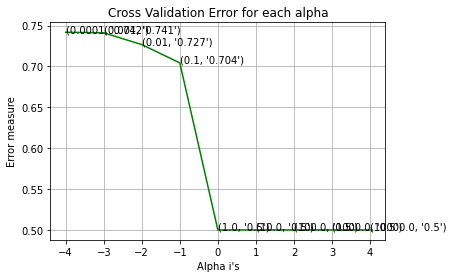

The Optimal C value is: 0.0001


In [18]:
alpha = np.logspace(-4,4,9)
cv_auc_score = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1',class_weight = 'balanced', loss='log', random_state=28)
    clf.fit(X_train_final[selected_features], y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(X_train_final[selected_features], y_train)
    y_pred_prob = sig_clf.predict_proba(X_val_final[selected_features])[:,1]
    cv_auc_score.append(roc_auc_score(y_val,y_pred_prob))
    print('For alpha {0}, cross validation AUC score {1}'.format(i,roc_auc_score(y_val,y_pred_prob)))
cv_plot(alpha, cv_auc_score)
print('The Optimal C value is:', alpha[np.argmax(cv_auc_score)])

For best alpha 0.0001, The Train AUC score is 0.7424504672704983
For best alpha 0.0001, The Cross validated AUC score is 0.7417569303876291
For best alpha 0.0001, The Test AUC score is 0.7448308064861653
The test AUC score is : 0.7448308064861653
The percentage of misclassified points 26.60% :


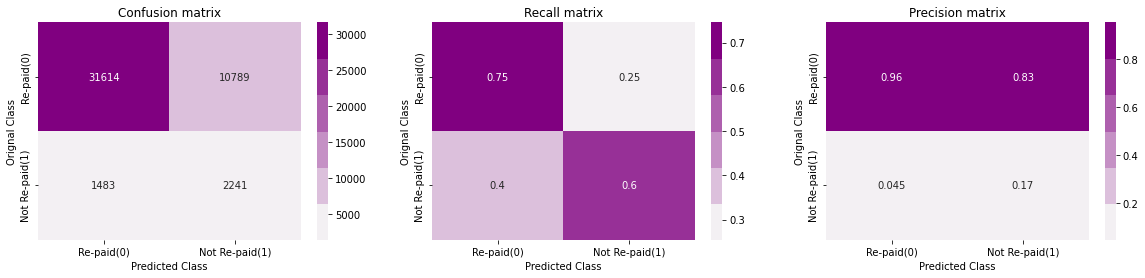

In [19]:
best_alpha = alpha[np.argmax(cv_auc_score)]
logreg = SGDClassifier(alpha = best_alpha, class_weight = 'balanced', penalty = 'l1', loss='log', random_state = 28)
logreg.fit(X_train_final[selected_features], y_train)
logreg_sig_clf = CalibratedClassifierCV(logreg, method='sigmoid')
logreg_sig_clf.fit(X_train_final[selected_features], y_train)
y_pred_prob = logreg_sig_clf.predict_proba(X_train_final[selected_features])[:,1]
print('For best alpha {0}, The Train AUC score is {1}'.format(best_alpha, roc_auc_score(y_train,y_pred_prob) ))    
y_pred_prob = logreg_sig_clf.predict_proba(X_val_final[selected_features])[:,1]
print('For best alpha {0}, The Cross validated AUC score is {1}'.format(best_alpha, roc_auc_score(y_val,y_pred_prob) ))  
y_pred_prob = logreg_sig_clf.predict_proba(X_test_final[selected_features])[:,1]
print('For best alpha {0}, The Test AUC score is {1}'.format(best_alpha, roc_auc_score(y_test,y_pred_prob) ))
y_pred = logreg.predict(X_test_final[selected_features])
print('The test AUC score is :', roc_auc_score(y_test,y_pred_prob))
print('The percentage of misclassified points {:05.2f}% :'.format((1-accuracy_score(y_test, y_pred))*100))
plot_confusion_matrix(y_test, y_pred)

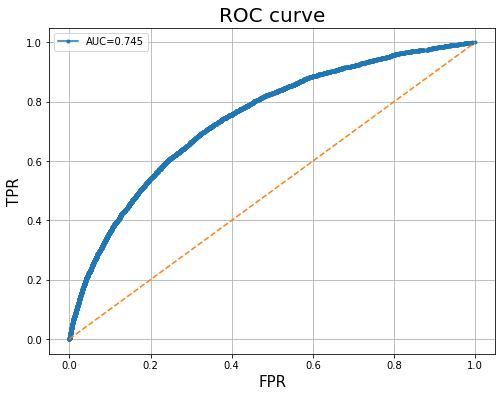

In [20]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test,y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
alpha = [200,500,1000,2000]
max_depth = [7, 10]
cv_auc_score = []
for i in alpha:
    for j in max_depth:
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j,class_weight='balanced',
                                     random_state=42, n_jobs=-1)
        clf.fit(X_train_final[selected_features], y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train_final[selected_features], y_train)
        y_pred_prob = sig_clf.predict_proba(X_val_final[selected_features])[:,1]
        cv_auc_score.append(roc_auc_score(y_val,y_pred_prob))
        print('For n_estimators {0}, max_depth {1} cross validation AUC score {2}'.
              format(i,j,roc_auc_score(y_val,y_pred_prob)))

## LightGBM

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.730899
[20]	valid_0's auc: 0.734485
[30]	valid_0's auc: 0.737631
[40]	valid_0's auc: 0.740614
[50]	valid_0's auc: 0.743936
[60]	valid_0's auc: 0.74629
[70]	valid_0's auc: 0.748413
[80]	valid_0's auc: 0.750033
[90]	valid_0's auc: 0.751477
[100]	valid_0's auc: 0.752647
[110]	valid_0's auc: 0.753472
[120]	valid_0's auc: 0.753994
[130]	valid_0's auc: 0.754504
[140]	valid_0's auc: 0.754997
[150]	valid_0's auc: 0.755413
[160]	valid_0's auc: 0.755749
[170]	valid_0's auc: 0.756212
[180]	valid_0's auc: 0.756415
[190]	valid_0's auc: 0.756788
[200]	valid_0's auc: 0.756852
[210]	valid_0's auc: 0.756955
[220]	valid_0's auc: 0.75688
[230]	valid_0's auc: 0.756973
[240]	valid_0's auc: 0.757222
[250]	valid_0's auc: 0.757402
[260]	valid_0's auc: 0.757452
[270]	valid_0's auc: 0.757538
[280]	valid_0's auc: 0.757494
[290]	valid_0's auc: 0.757619
[300]	valid_0's auc: 0.757608
[310]	valid_0's auc: 0.757736
[320]	valid_0's au

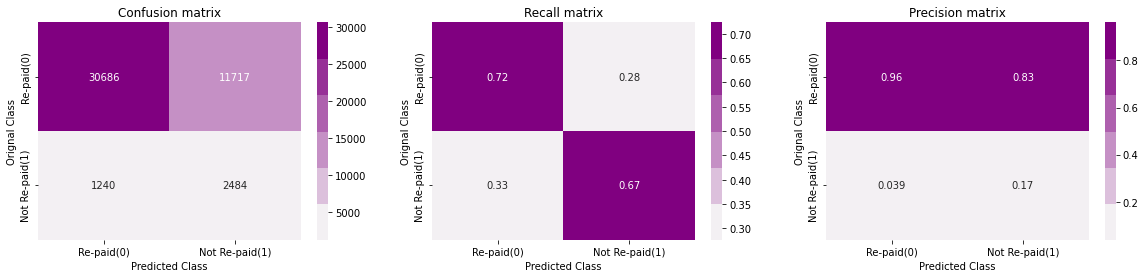

In [ ]:
weight = np.ones((len(X_train_final),), dtype=int)
for i in range(len(X_train_final)):
    if y_train[i]== 0:
        weight[i]=1
    else:
        weight[i]=11

train_data=lgb.Dataset(X_train_final[selected_features], label = y_train, weight= weight )
valid_data=lgb.Dataset(X_val_final[selected_features], label = y_val)
cv_auc_score = []
max_depth = [3, 5, 7, 10]
for i in max_depth:
    
    params = {'boosting_type': 'gbdt',
          'max_depth' : i,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 32,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 0.7,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 20,
          'reg_lambda': 20,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 10,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }
lgbm = lgb.train(params,
                 train_data,
                 2500,
                 valid_sets=valid_data,
                 early_stopping_rounds= 100,
                 verbose_eval= 10
                 )
y_pred_prob = lgbm.predict(X_val_final[selected_features])
cv_auc_score.append(roc_auc_score(y_val,y_pred_prob))
print('For  max_depth {0} and some other parameters, cross validation AUC score {1}'.format(i,roc_auc_score(y_val,y_pred_prob)))
print('The optimal  max_depth: ', max_depth[np.argmax(cv_auc_score)])
params = {'boosting_type': 'gbdt',
          'max_depth' : max_depth[np.argmax(cv_auc_score)],
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 32,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 0.7,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 20,
          'reg_lambda': 20,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 10,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }
lgbm = lgb.train(params,
                 train_data,
                 2500,
                 valid_sets=valid_data,
                 early_stopping_rounds= 100,
                 verbose_eval= 10
                 )
y_pred_prob = lgbm.predict(X_train_final[selected_features])
print('For best max_depth {0}, The Train AUC score is {1}'.format(max_depth[np.argmax(cv_auc_score)], 
                                                                  roc_auc_score(y_train,y_pred_prob) ))    
y_pred_prob = lgbm.predict(X_val_final[selected_features])
print('For best max_depth {0}, The Cross validated AUC score is {1}'.format(max_depth[np.argmax(cv_auc_score)], 
                                                                            roc_auc_score(y_val,y_pred_prob) ))  
y_pred_prob = lgbm.predict(X_test_final[selected_features])
print('For best max_depth {0}, The Test AUC score is {1}'.format(max_depth[np.argmax(cv_auc_score)], 
                                                                 roc_auc_score(y_test,y_pred_prob) ))
y_pred = np.ones((len(X_test_final),), dtype=int)
for i in range(len(y_pred_prob)):
    if y_pred_prob[i]<=0.5:
        y_pred[i]=0
    else:
        y_pred[i]=1
print('The test AUC score is :', roc_auc_score(y_test,y_pred_prob))
print('The percentage of misclassified points {:05.2f}% :'.format((1-accuracy_score(y_test, y_pred))*100))
plot_confusion_matrix(y_test, y_pred)

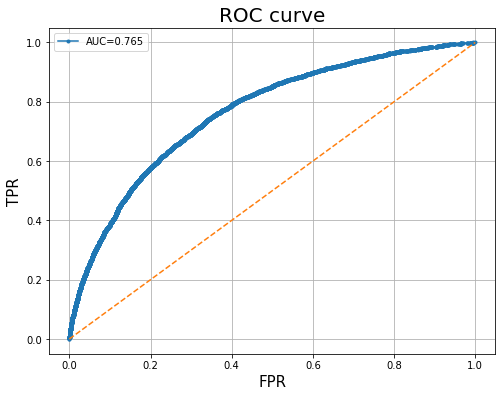

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test,y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

LightGBM model gives the best performance than others.

## Final Model

In [ ]:
# Saving the final model LightGBM as pickle file for the future use in productionizing the model
with open('final_model.pkl','wb') as fp:
    pickle.dump(lgbm, fp)

# Conclusion and Suggestion

1.   Best machine learning model that we got for this loan data is a model using Lightgbm metrics.
2.   Do Hyperparameter Tuning to improve performance of model



# References
https://www.kaggle.com/competitions/home-credit-default-risk/

https://www.kaggle.com/c/home-credit-default-risk/discussion/64821

https://medium.com/@praveenkotha/home-credit-default-risk-end-to-end-machine-learning-project-1871f52e3ef2